# EAF Coffea-Casa Benchmark Example 4

In [1]:
import numpy as np
%matplotlib inline
from coffea import hist
import coffea.processor as processor
import awkward as ak
from coffea.nanoevents import schemas

In [2]:
# This program plots an event-level variable (MET) based on conditionals with its associated Jet arrays 
#(in this case, where at least 2 have pT > 40)

class Processor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat("dataset", "")
        MET_axis = hist.Bin("MET_pt", "MET [GeV]", 50, 0, 125)
        
        self._accumulator = processor.dict_accumulator({
            'MET_pt': hist.Hist("Counts", dataset_axis, MET_axis),
            'cutflow': processor.defaultdict_accumulator(int)
        })
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, events):
        output = self.accumulator.identity()
        
        dataset = events.metadata["dataset"]
        
        jets = events.Jet
        MET = events.MET.pt
        
        output['cutflow']['all events'] += ak.size(jets, axis=0)
        
        # We want jets with a pt of at least 40.
        pt_min = (jets.pt > 40)

        # We want MET where the above condition is met for at least two jets. 
        #The above is a list of Boolean sublists generated from the jet sublists (True if condition met, False if not). 
        #If we sum each sublist, we get the amount of jets matching the condition (since True = 1).
        good_MET = MET[(ak.sum(pt_min, axis=1) >= 2)]
        output['cutflow']['final events'] += ak.size(good_MET, axis=0)
        
        output['MET_pt'].fill(dataset=dataset, MET_pt=good_MET)
        return output

    def postprocess(self, accumulator):
        return accumulator

## Please see EAF Coffea-Casa Benchmark Example 1 or the README for Local Cluster Instructions

In [3]:
#Do NOT run this cell, it will NOT work for your local cluster.
from dask.distributed import Client

client = Client("tcp://127.0.0.1:35275")
client

Client Scheduler: tcp://127.0.0.1:35275 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 1 Cores: 3 Memory: 3.22 GB


In [4]:
fileset = {'SingleMu' : ["root://eospublic.cern.ch//eos/root-eos/benchmark/Run2012B_SingleMu.root"]}

executor = processor.DaskExecutor(client=client)

run = processor.Runner(executor=executor,
                        schema=schemas.NanoAODSchema,
                        savemetrics=True
                      )

output, metrics = run(fileset, "Events", processor_instance=Processor())

metrics

[                                        ] | 0% Completed |  0.1s

/opt/conda/lib/python3.8/site-packages/dask/dataframe/utils.py:367: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/opt/conda/lib/python3.8/site-packages/dask/dataframe/utils.py:367: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/opt/conda/lib/python3.8/site-packages/dask/dataframe/utils.py:367: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)


{'bytesread': 1992683441,
 'columns': {'Jet_pt', 'MET_pt', 'nJet'},
 'entries': 53446198,
 'processtime': 384.52167677879333,
 'chunks': 534}

<AxesSubplot:xlabel='MET [GeV]', ylabel='Counts'>

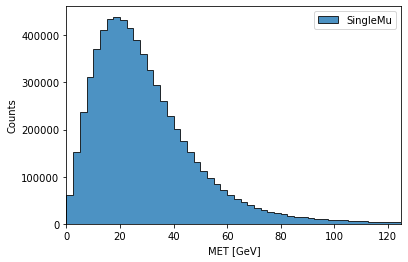

In [5]:
hist.plot1d(output['MET_pt'], overlay='dataset', fill_opts={'edgecolor': (0,0,0,0.3), 'alpha': 0.8})

In [6]:
for key, value in output['cutflow'].items():
    print(key, value)

all events 53446198
final events 6665702
